In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import pandas as pd
import seaborn as sns
from scipy.signal import medfilt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
import torch
from IPython.display import Audio
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [2]:
circle_healthy_path = "newhandspd/HealthyCircle/"
circle_parkinson_path = "newhandspd/PatientCircle/"
meander_healthy_path = "newhandspd/HealthyMeander/"
meander_parkinson_path = "newhandspd/PatientMeander/"
spiral_healthy_path = "newhandspd/HealthySpiral/"
spiral_parkinson_path = "newhandspd/PatientSpiral/"

def load_images(folder):
    images = []
    if not os.path.exists(folder):
        print(f"[WARN] Folder not found: {folder}")
        return images
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                print(f"[WARN] Unable to read image: {file}")
    print(f"[INFO] Loaded {len(images)} images from {folder}")
    return images

# Load images without 'train' suffix
spiral_healthy = load_images(spiral_healthy_path)
spiral_parkinson = load_images(spiral_parkinson_path)
circle_healthy = load_images(circle_healthy_path)
circle_parkinson = load_images(circle_parkinson_path)
meander_healthy = load_images(meander_healthy_path)
meander_parkinson = load_images(meander_parkinson_path)

# Combine all images and labels for splitting
all_images = (
    spiral_healthy + spiral_parkinson +
    circle_healthy + circle_parkinson +
    meander_healthy + meander_parkinson
)


[INFO] Loaded 140 images from newhandspd/HealthySpiral/
[INFO] Loaded 124 images from newhandspd/PatientSpiral/
[INFO] Loaded 35 images from newhandspd/HealthyCircle/
[INFO] Loaded 31 images from newhandspd/PatientCircle/
[INFO] Loaded 140 images from newhandspd/HealthyMeander/
[INFO] Loaded 124 images from newhandspd/PatientMeander/


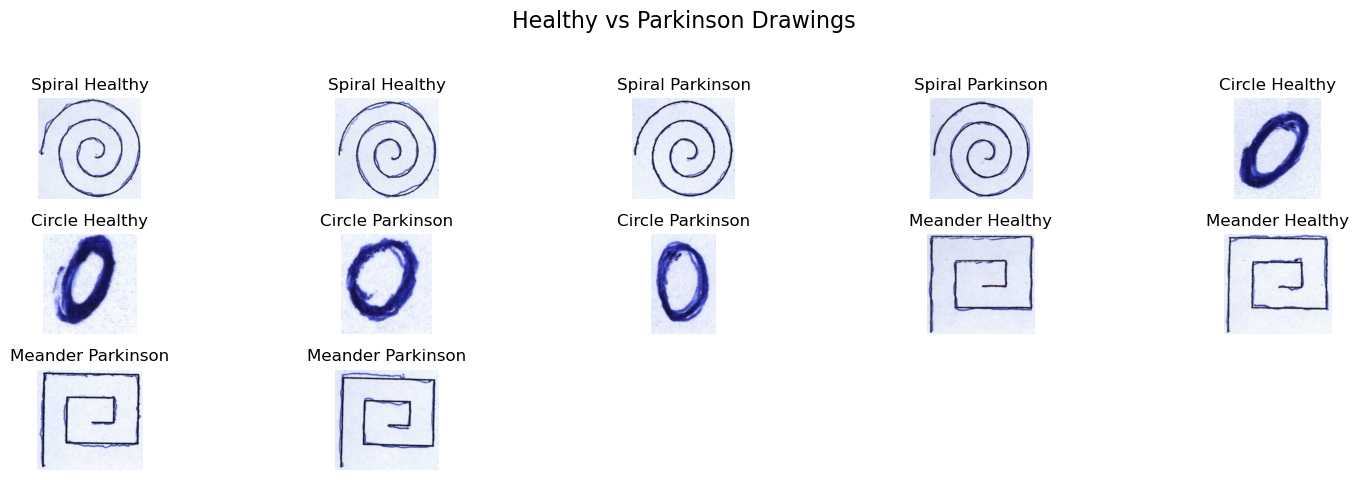

In [3]:

# Labels: 0 = Healthy, 1 = Parkinson
all_labels = (
    [0]*len(spiral_healthy) + [1]*len(spiral_parkinson) +
    [0]*len(circle_healthy) + [1]*len(circle_parkinson) +
    [0]*len(meander_healthy) + [1]*len(meander_parkinson)
)

# Split dataset (example: 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Plot example images from dataset (5 examples total)
plt.figure(figsize=(15, 5))

plot_images = [
    (spiral_healthy, "Spiral Healthy"),
    (spiral_parkinson, "Spiral Parkinson"),
    (circle_healthy, "Circle Healthy"),
    (circle_parkinson, "Circle Parkinson"),
    (meander_healthy, "Meander Healthy"),
    (meander_parkinson, "Meander Parkinson"),
]

idx = 1
for images, title in plot_images:
    for i in range(min(2, len(images))):  # Plot max 2 images per class
        plt.subplot(3, 5, idx)
        plt.imshow(images[i])
        plt.title(title)
        plt.axis('off')
        idx += 1

plt.suptitle("Healthy vs Parkinson Drawings", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from scipy.signal import wiener
import numpy as np
import cv2  # For grayscale conversion, if images are RGB

# --- Assuming you already have these lists loaded ---
# spiral_healthy, spiral_parkinson, circle_healthy, circle_parkinson, meander_healthy, meander_parkinson
# Each list contains images as numpy arrays or compatible arrays

# Create combined image and label lists
spiral_images = spiral_healthy + spiral_parkinson
spiral_labels = [0] * len(spiral_healthy) + [1] * len(spiral_parkinson)

circle_images = circle_healthy + circle_parkinson
circle_labels = [0] * len(circle_healthy) + [1] * len(circle_parkinson)

meander_images = meander_healthy + meander_parkinson
meander_labels = [0] * len(meander_healthy) + [1] * len(meander_parkinson)

all_images = spiral_images + circle_images + meander_images
all_labels = spiral_labels + circle_labels + meander_labels

print(f"Total images: {len(all_images)}")
print(f"Total labels: {len(all_labels)}")

# Function to convert RGB to grayscale if needed
def to_grayscale(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Convert RGB to grayscale
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        # Already grayscale or single channel
        return image

# Function to apply adaptive Wiener filter
def adaptive_wiener_filter(image):
    # image is assumed to be grayscale numpy array
    filtered_img = wiener(image, mysize=(5,5))
    return filtered_img

# Preprocess all images: convert to grayscale and apply Wiener filter
all_images_processed = []
for img in all_images:
    gray_img = to_grayscale(np.array(img))
    filtered_img = adaptive_wiener_filter(gray_img)
    all_images_processed.append(filtered_img)

print("Applied grayscale conversion and adaptive Wiener filter on all images.")

# Now split into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    all_images_processed, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Total images: 594
Total labels: 594
Applied grayscale conversion and adaptive Wiener filter on all images.
Train set size: 475
Test set size: 119


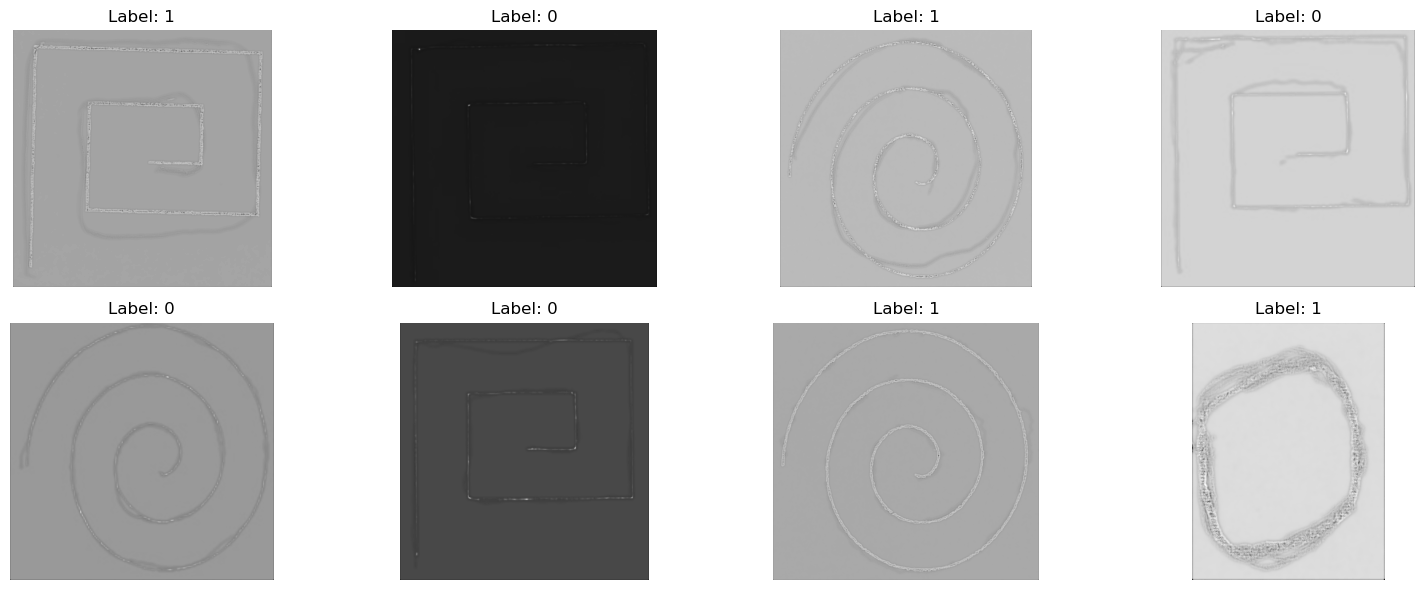

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.models import densenet121, DenseNet121_Weights
from PIL import Image
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load DenseNet121 pretrained model and its weights
weights = DenseNet121_Weights.DEFAULT
densenet = densenet121(weights=weights).to(device)
densenet.eval()

# Define transforms expected by DenseNet
transform = weights.transforms()

# Feature extraction function
def extract_features(images):
    features = []
    with torch.no_grad():
        for img in images:
            # Step 1: Convert to uint8 if image is float
            if img.max() <= 1.0:
                img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

            # Step 2: Convert grayscale to 3-channel RGB
            if img.ndim == 2:  # shape (H, W)
                img = np.stack([img]*3, axis=-1)
            elif img.shape[2] == 1:  # shape (H, W, 1)
                img = np.concatenate([img]*3, axis=-1)

            # Step 3: Convert to PIL and apply transforms
            img_pil = Image.fromarray(img).convert("RGB")
            input_tensor = transform(img_pil).unsqueeze(0).to(device)  # (1, 3, H, W)

            # Step 4: Extract features from DenseNet
            output = densenet.features(input_tensor)
            pooled = torch.nn.functional.adaptive_avg_pool2d(output, (1, 1))
            feature_vector = torch.flatten(pooled, 1)
            features.append(feature_vector.cpu().numpy().squeeze())
    return np.array(features)

# ==== Example Usage ====
# Assuming X_train and X_test are lists of grayscale/wiener filtered NumPy images
# Example: X_train[0].shape == (H, W) or (H, W, 1)
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

print("Train features shape:", X_train_features.shape)
print("Test features shape:", X_test_features.shape)


Train features shape: (475, 1024)
Test features shape: (119, 1024)


Test Accuracy: 0.9076
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.98      0.84      0.91        63
   Parkinson       0.85      0.98      0.91        56

    accuracy                           0.91       119
   macro avg       0.91      0.91      0.91       119
weighted avg       0.92      0.91      0.91       119



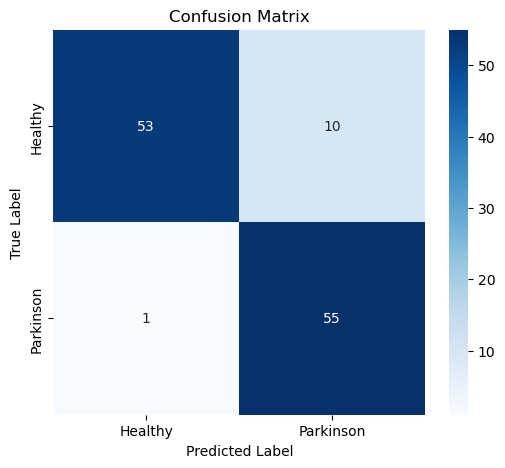

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_features, y_train)

# Predict on test set
y_pred = clf.predict(X_test_features)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Healthy", "Parkinson"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Parkinson"],
            yticklabels=["Healthy", "Parkinson"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Gradient Boosting

Test Accuracy: 0.9244
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.92      0.93        63
   Parkinson       0.91      0.93      0.92        56

    accuracy                           0.92       119
   macro avg       0.92      0.92      0.92       119
weighted avg       0.92      0.92      0.92       119



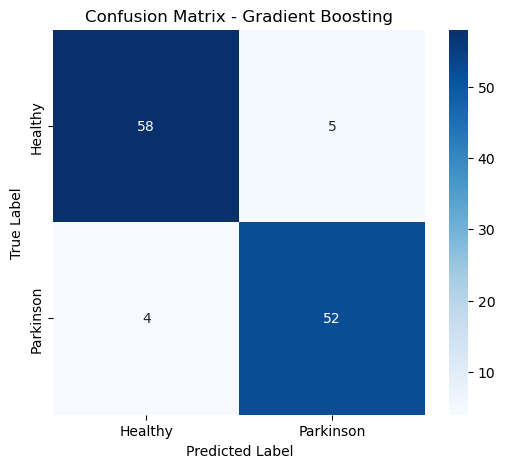

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Train the model
gb_clf.fit(X_train_features, y_train)

# Predict on test data
y_pred = gb_clf.predict(X_test_features)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Healthy", "Parkinson"]))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Parkinson"],
            yticklabels=["Healthy", "Parkinson"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


# Ensemble Learning: Combining Random Forest and Gradient Boosting

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define individual models
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Combine using VotingClassifier
ensemble = VotingClassifier(
    estimators=[('rf', rfc), ('gb', gbc)],
    voting='soft'  # use 'hard' for majority class, 'soft' for probability-based
)

# Fit and predict
ensemble.fit(X_train_features, y_train)
y_pred = ensemble.predict(X_test_features)

# Evaluation
print("Voting Classifier (RF + GB) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Voting Classifier (RF + GB) Results:
Accuracy: 0.9327731092436975
              precision    recall  f1-score   support

           0       0.97      0.90      0.93        63
           1       0.90      0.96      0.93        56

    accuracy                           0.93       119
   macro avg       0.93      0.93      0.93       119
weighted avg       0.93      0.93      0.93       119



# Parameter Adjustment

In [10]:
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, accuracy_score
# import time

# # ----------------------------
# # Random Forest Grid Search
# # ----------------------------
# param_grid_rf = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
# }

# rf = RandomForestClassifier(random_state=42)
# grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# start_time = time.time()
# grid_rf.fit(X_train_features, y_train)
# print(f"Best RF Params: {grid_rf.best_params_}")
# print(f"RF Grid Search Time: {time.time() - start_time:.2f}s")

# # ----------------------------
# # Gradient Boosting Grid Search
# # ----------------------------
# param_grid_gb = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [3, 5],
#     'subsample': [1.0, 0.8],
# }

# gb = GradientBoostingClassifier(random_state=42)
# grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# start_time = time.time()
# grid_gb.fit(X_train_features, y_train)
# print(f"Best GB Params: {grid_gb.best_params_}")
# print(f"GB Grid Search Time: {time.time() - start_time:.2f}s")

# # ----------------------------
# # Evaluate Tuned Models
# # ----------------------------
# best_rf = grid_rf.best_estimator_
# best_gb = grid_gb.best_estimator_

# y_pred_rf = best_rf.predict(X_test_features)
# y_pred_gb = best_gb.predict(X_test_features)

# print("\n🎯 Tuned Random Forest:")
# print("Accuracy:", accuracy_score(y_test, y_pred_rf))
# print(classification_report(y_test, y_pred_rf))

# print("\n🎯 Tuned Gradient Boosting:")
# print("Accuracy:", accuracy_score(y_test, y_pred_gb))
# print(classification_report(y_test, y_pred_gb))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RF Grid Search Time: 43.33s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best GB Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
GB Grid Search Time: 468.73s

🎯 Tuned Random Forest:
Accuracy: 0.8907563025210085
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        63
           1       0.83      0.96      0.89        56

    accuracy                           0.89       119
   macro avg       0.90      0.89      0.89       119
weighted avg       0.90      0.89      0.89       119


🎯 Tuned Gradient Boosting:
Accuracy: 0.907563025210084
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        63
           1       0.88      0.93      0.90        56

    accuracy          

In [11]:
from sklearn.ensemble import VotingClassifier

# Use the best estimators from grid search
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('gb', best_gb)],
    voting='soft'
)

voting_clf.fit(X_train_features, y_train)
y_pred_voting = voting_clf.predict(X_test_features)

# Evaluate ensemble
print("\n🎯 Voting Classifier (Tuned RF + GB):")
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))



🎯 Voting Classifier (Tuned RF + GB):
Accuracy: 0.907563025210084
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        63
           1       0.88      0.93      0.90        56

    accuracy                           0.91       119
   macro avg       0.91      0.91      0.91       119
weighted avg       0.91      0.91      0.91       119



# Stacking Classifier


🎯 Stacking Classifier:
Accuracy: 0.8487394957983193
Balanced Accuracy: 0.8482142857142857
Macro F1: 0.8482142857142857

Threshold: 0.732 (best Balanced Accuracy)
Accuracy (tuned): 0.8907563025210085
Balanced Accuracy (tuned): 0.8849206349206349
Macro F1 (tuned): 0.8881983088819831


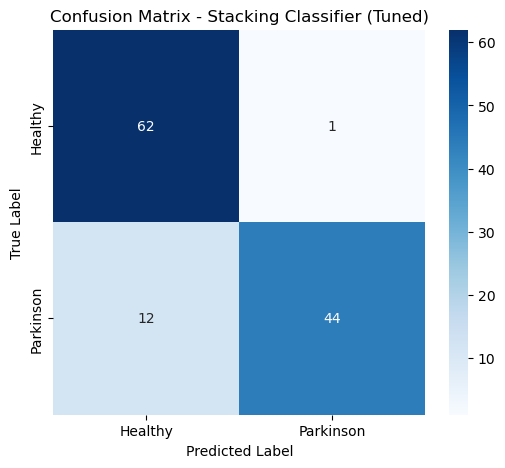

In [13]:
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Update stacking classifier with fairness metrics and threshold tuning
stack_clf = StackingClassifier(
    estimators=[('rf', best_rf), ('gb', best_gb)],
    final_estimator=GradientBoostingClassifier(random_state=42)
    )

stack_clf.fit(X_train_features, y_train)
y_pred_stack = stack_clf.predict(X_test_features)
y_prob_stack = stack_clf.predict_proba(X_test_features)[:, 1]

# Threshold tuning for best balanced accuracy
fpr, tpr, thresholds = roc_curve(y_test, y_prob_stack)
balanced_accuracies = [balanced_accuracy_score(y_test, y_prob_stack >= thr) for thr in thresholds]
best_thr = thresholds[np.argmax(balanced_accuracies)]
y_pred_thr_stack = (y_prob_stack >= best_thr).astype(int)

# Evaluation with fairness metrics
print("\n🎯 Stacking Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_stack))
print("Macro F1:", f1_score(y_test, y_pred_stack, average='macro'))

print(f"\nThreshold: {best_thr:.3f} (best Balanced Accuracy)")
print("Accuracy (tuned):", accuracy_score(y_test, y_pred_thr_stack))
print("Balanced Accuracy (tuned):", balanced_accuracy_score(y_test, y_pred_thr_stack))
print("Macro F1 (tuned):", f1_score(y_test, y_pred_thr_stack, average='macro'))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_thr_stack)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Parkinson"],
            yticklabels=["Healthy", "Parkinson"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Stacking Classifier (Tuned)")
plt.show()


# Weighted Soft Voting Classifier (GB > RF)

In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Weighted Voting Classifier (giving more weight to Gradient Boosting)
weighted_voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('gb', best_gb)],
    voting='soft',
    weights=[1, 2]  # GB gets double the influence
)

# Train
weighted_voting_clf.fit(X_train_features, y_train)

# Predict
y_pred_weighted = weighted_voting_clf.predict(X_test_features)

# Evaluate
print("\n🎯 Weighted Voting Classifier (1 RF : 2 GB):")
print("Accuracy:", accuracy_score(y_test, y_pred_weighted))
print(classification_report(y_test, y_pred_weighted))



🎯 Weighted Voting Classifier (1 RF : 2 GB):
Accuracy: 0.907563025210084
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        63
           1       0.88      0.93      0.90        56

    accuracy                           0.91       119
   macro avg       0.91      0.91      0.91       119
weighted avg       0.91      0.91      0.91       119



 # Weighted Voting of GB and Stacking

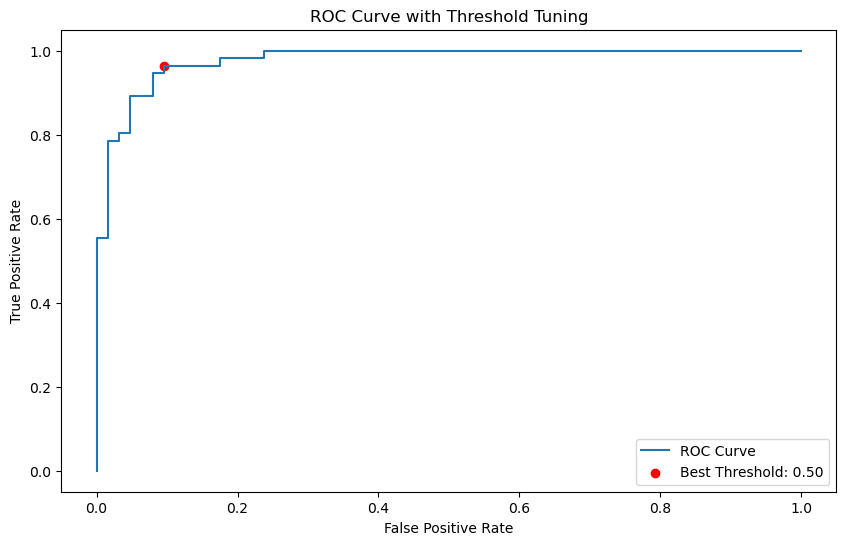

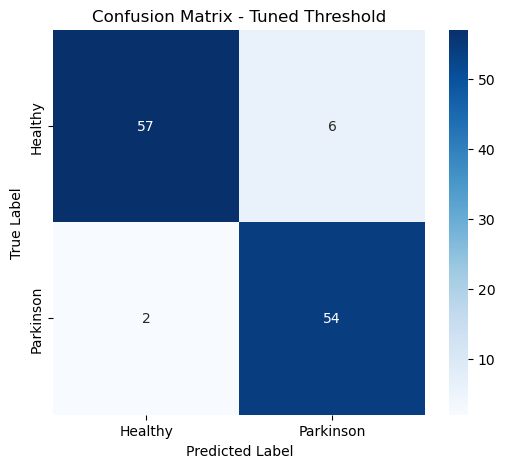


🎯 Voting of Calibrated GB + Stacking (Weighted 2:1):
Accuracy (default 0.5): 0.9327731092436975
Balanced Accuracy: 0.933531746031746
Macro F1: 0.9326542161856253
MCC: 0.8658372667404673
Cohen's Kappa: 0.8653465346534653

Classification Report (default 0.5):
              precision    recall  f1-score   support

     Healthy       0.95      0.92      0.94        63
   Parkinson       0.91      0.95      0.93        56

    accuracy                           0.93       119
   macro avg       0.93      0.93      0.93       119
weighted avg       0.93      0.93      0.93       119


Threshold: 0.496 (best F1)
Accuracy (tuned): 0.9327731092436975
Balanced Accuracy (tuned): 0.9345238095238095
Macro F1 (tuned): 0.9327303561334087
MCC (tuned): 0.8675734065882892
Cohen's Kappa (tuned): 0.8656126482213439

Classification Report (tuned):
              precision    recall  f1-score   support

     Healthy       0.97      0.90      0.93        63
   Parkinson       0.90      0.96      0.93        

In [15]:
# --- Improved Ensemble and Evaluation Pipeline ---
from sklearn.ensemble import VotingClassifier, StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score, f1_score, matthews_corrcoef, cohen_kappa_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Use class weights for fairness
best_rf.set_params(class_weight='balanced')
best_gb.set_params(**({'subsample': 1.0}))  

# 2. Calibrate probabilities for both base models
cal_rf = CalibratedClassifierCV(best_rf, method='isotonic', cv=3)
cal_gb = CalibratedClassifierCV(best_gb, method='isotonic', cv=3)
cal_rf.fit(X_train_features, y_train)
cal_gb.fit(X_train_features, y_train)

# 3. Stacking with calibrated base models
stacking_clf = StackingClassifier(
    estimators=[('rf', cal_rf), ('gb', cal_gb)],
    final_estimator=GradientBoostingClassifier(n_estimators=100, random_state=42)
)
stacking_clf.fit(X_train_features, y_train)

# 4. Weighted Voting: GB + Stacking (GB weighted more)
combo_voting = VotingClassifier(
    estimators=[('gb', cal_gb), ('stack', stacking_clf)],
    voting='soft',
    weights=[2, 1]
)
combo_voting.fit(X_train_features, y_train)
y_pred_combo = combo_voting.predict(X_test_features)
y_prob_combo = combo_voting.predict_proba(X_test_features)[:, 1]

# 5. Threshold tuning for best F1/balanced accuracy
fpr, tpr, thresholds = roc_curve(y_test, y_prob_combo)
f1s = [f1_score(y_test, y_prob_combo >= thr) for thr in thresholds]
best_thr = thresholds[np.argmax(f1s)]
y_pred_thr = (y_prob_combo >= best_thr).astype(int)

# Visualization of ROC curve and threshold impact
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.scatter(fpr[np.argmax(f1s)], tpr[np.argmax(f1s)], color='red', label=f"Best Threshold: {best_thr:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Threshold Tuning")
plt.legend()
plt.show()

# Confusion matrix visualization for tuned threshold
cm_tuned = confusion_matrix(y_test, y_pred_thr)
plt.figure(figsize=(6,5))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Parkinson"],
            yticklabels=["Healthy", "Parkinson"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Tuned Threshold")
plt.show()

# 6. Evaluation with multiple metrics
print("\n🎯 Voting of Calibrated GB + Stacking (Weighted 2:1):")
print("Accuracy (default 0.5):", accuracy_score(y_test, y_pred_combo))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_combo))
print("Macro F1:", f1_score(y_test, y_pred_combo, average='macro'))
print("MCC:", matthews_corrcoef(y_test, y_pred_combo))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred_combo))
print("\nClassification Report (default 0.5):")
print(classification_report(y_test, y_pred_combo, target_names=["Healthy", "Parkinson"]))

print(f"\nThreshold: {best_thr:.3f} (best F1)")
print("Accuracy (tuned):", accuracy_score(y_test, y_pred_thr))
print("Balanced Accuracy (tuned):", balanced_accuracy_score(y_test, y_pred_thr))
print("Macro F1 (tuned):", f1_score(y_test, y_pred_thr, average='macro'))
print("MCC (tuned):", matthews_corrcoef(y_test, y_pred_thr))
print("Cohen's Kappa (tuned):", cohen_kappa_score(y_test, y_pred_thr))
print("\nClassification Report (tuned):")
print(classification_report(y_test, y_pred_thr, target_names=["Healthy", "Parkinson"]))